# Setting up depedencies

In [8]:
%load_ext rpy2.ipython

In [9]:
import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("src"))
import analysis
reload(analysis)

/home/adfaure/Projects/ptask-eval/analysis


<module 'analysis' from '/home/adfaure/Projects/ptask-eval/analysis/src/analysis.py'>

In [10]:
# Load all and untar
instances = [ 
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_no_kali/"),
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_noper/"),
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per10s/"),
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per10sidle20sinter/"),
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/"),
    analysis.Instances("../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_periods30s/"),
            ]

Print the runtimes for each instance of each configuration.

# Vizualisations
## Progress of the parallel DGEMM application with different interferences

In [12]:
for insts in instances:
    pass
    print("--")
    print("instances mean runtime: ", insts.name, insts.get_mean_runtime())

--
instances mean runtime:  None nan
--
instances mean runtime:  None nan
--
instances mean runtime:  None nan
--
instances mean runtime:  None nan
--
instances mean runtime:  None nan
--
instances mean runtime:  None nan


/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
runtimes = dict()

for instances_group in instances:
    for id_ in instances_group.instances:
        if  instances_group.name not in runtimes:
            runtimes[instances_group.name] = []

        runtimes[instances_group.name].append(instances_group.instances[id_].get_runtime2())
    
df = pd.DataFrame(data=runtimes)

df.to_csv("/tmp/test.csv")
df

Empty DataFrame
Columns: []
Index: []

In [15]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

test = read_csv("/tmp/test.csv")
    
test = test %>% gather(col, val, -X1) %>% mutate(X1 = as.factor(X1))

test %>% ggplot(aes(y = val, x = col, group=X1)) + 
    geom_point(position=position_dodge(width=0.3)) +
    scale_colour_viridis_d() + expand_limits(x = 0, y = 0)


/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Missing column names filled in: 'X1' [1] 

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in FUN(X[[i]], ...) : object 'val' not found


/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  X1 = col_double(),
  loop = col_double(),
  max_bcast_begin = col_double(),
  min_bcast_begin = col_double(),
  max_bcast_end = col_double(),
  min_bcast_end = col_double(),
  max_comp_begins = col_logical(),
  min_comp_begins = col_logical(),
  max_comp_end = col_double(),
  min_comp_end = col_double()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 7 in image

  warnings.warn(x, RRuntimeWarning)


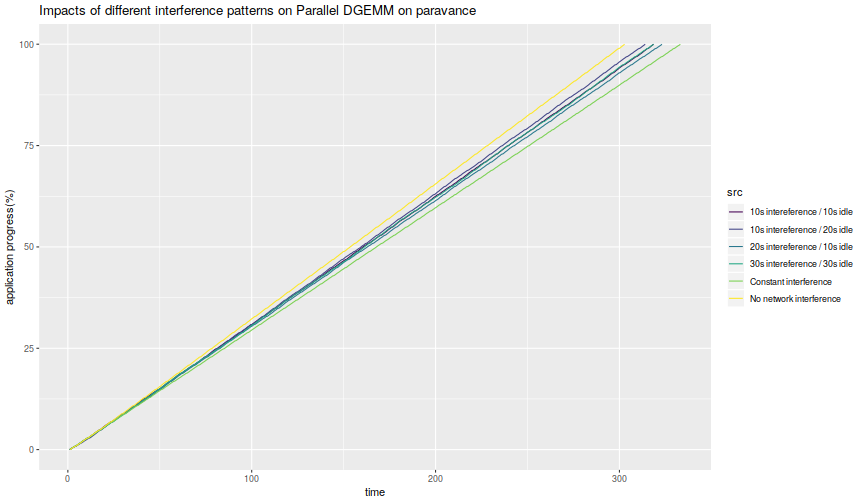

In [17]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

test =  read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_no_kali/3f44e0e0/mpi_progress.csv") %>%
                  mutate(src = "No network interference") %>% 
        bind_rows( read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_noper/22155b88/mpi_progress.csv") %>%
                  mutate(src = "Constant interference") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per10s/3fddbe28/mpi_progress.csv") %>%
                  mutate(src = "10s intereference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_periods30s/02e0fa1c/mpi_progress.csv") %>%
                  mutate(src = "30s intereference / 30s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per10sidle20sinter/5b13ba54/mpi_progress.csv") %>%
                  mutate(src = "20s intereference / 10s idle") ) %>%
        bind_rows( read_csv("../experiments/g5k/data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/aa69368b/mpi_progress.csv") %>%
                  mutate(src = "10s intereference / 20s idle") )

test = test %>% mutate(progress = loop/max(loop)*100)
test %>% ggplot(aes(x = max_comp_end, y = progress)) + ylab("application progress(%)") + xlab("time") + 
    geom_line(aes(color = src)) + ggtitle("Impacts of different interference patterns on Parallel DGEMM on paravance") + 
    scale_colour_viridis_d() + ggsave("/tmp/progress.png")

# Details of 1 instance for each differents kind of interferences

## periodic 30s interferences / 30s idle

/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


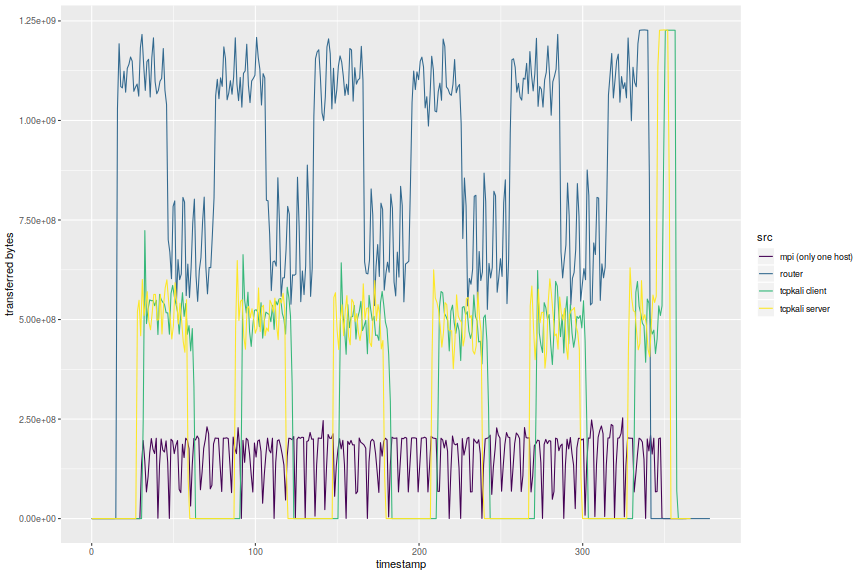

In [9]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data_dirty/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_periods30s/02e0fa1c/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-26.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

## periodic 30s interferences / 30s idle

/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


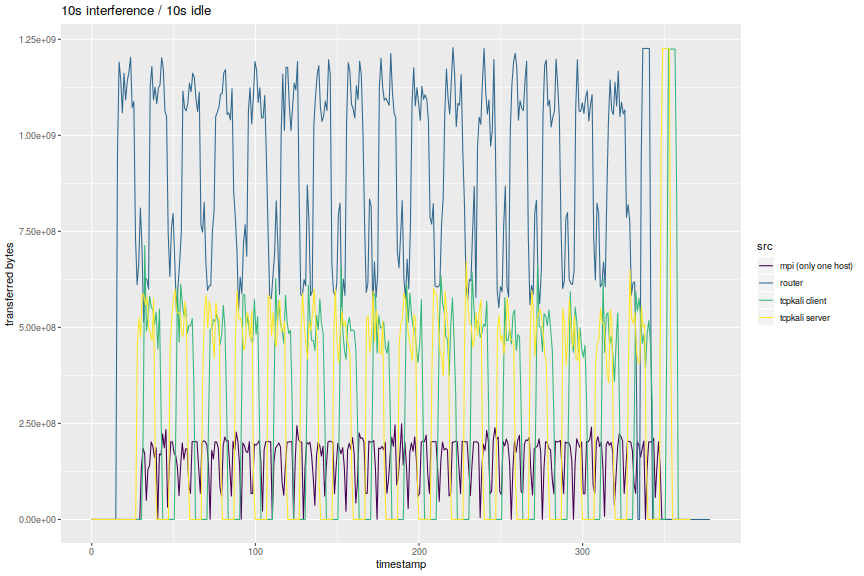

In [10]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per10s/8f0c4492//"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-26.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    ggtitle("10s interference / 10s idle") +
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

## No Interference

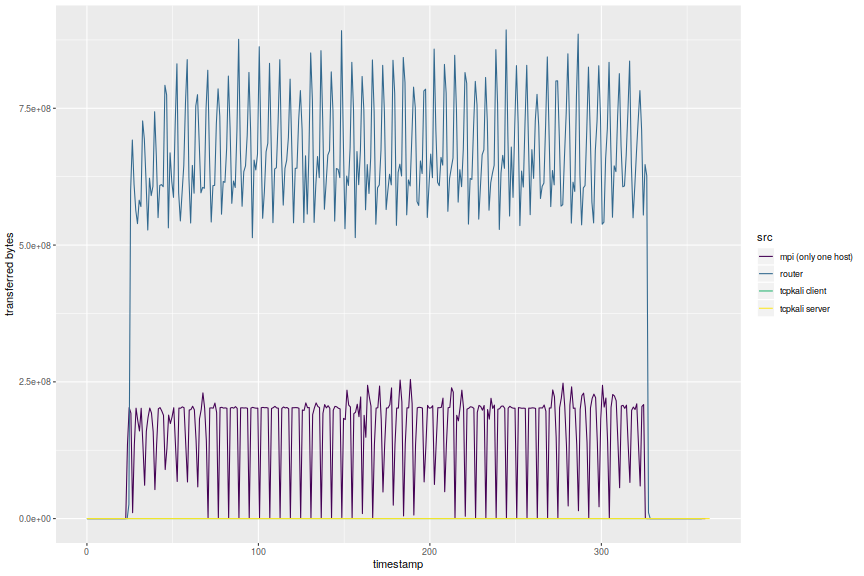

In [13]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_no_kali/3f44e0e0/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-26.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

## Constant interference

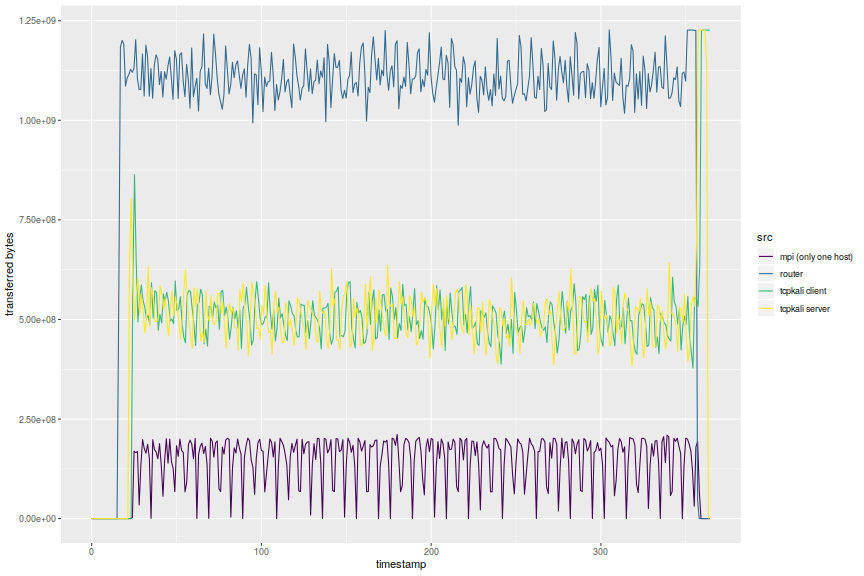

In [43]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_noper/1b2e1453/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-26.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

## 10s interferenc / 20s idle

In [1]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/9f93c63f/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-12.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-12.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) )

test %>% mutate() %>% select(timestamp, src, txb, rxb) %>%
    gather(col, val, -timestamp, -src) %>% ggplot(aes(x = timestamp, y = val)) +
    ylab("transferred bytes") + facet_wrap(.~col) +
    geom_line(aes(color = src)) + theme_bw() +
    scale_colour_viridis_d() + ggsave("/tmp/plot.png")
    

UsageError: Cell magic `%%R` not found.


In [6]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/d91c789a/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-26.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-11.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = rxb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggtitle("20s idle / 10s interference")


Error: '../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/d91c789a/paravance-1.rennes.grid5000.fr.eno1.mojitos.csv' does not exist in current working directory ('/home/adfaure/Projects/colmet_book/experiments/interferences/analysis').


/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Error: '../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_per20sidle10sinter/d91c789a/paravance-1.rennes.grid5000.fr.eno1.mojitos.csv' does not exist in current working directory ('/home/adfaure/Projects/colmet_book/experiments/interferences/analysis').

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: 1: Missing column names filled i

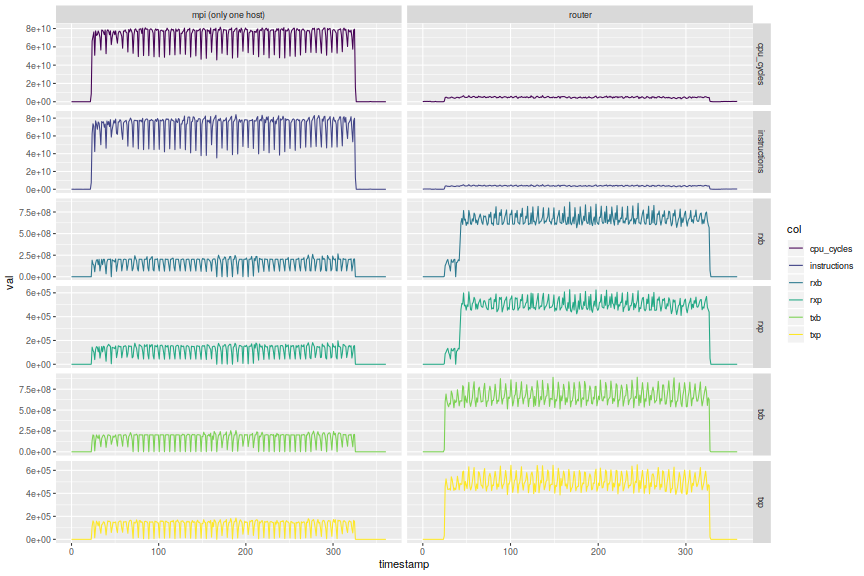

In [30]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance/paravance_80K_256ranks_1bcast_50subdiv/256c_no_kali/3f44e0e0/"

test = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
       bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) )

        
test %>% select(-X8) %>% gather(col, val, -timestamp, -src) %>% ggplot(aes(x = timestamp, y = val)) + 
    ylab("val") + 
    geom_line(aes(color = col)) + facet_grid(col~src, scales="free") +
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

# Anomalies

I found out that some nodes have activity on the eno1 interface.
paravance-33,29 and 13.

I am working on a fix.

/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


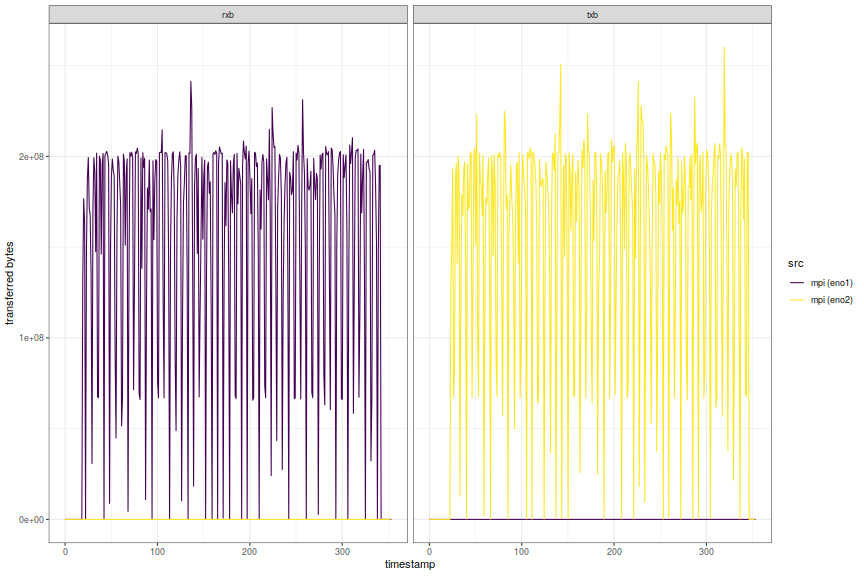

In [5]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/paravance_bug_interface_1/paravance_80K_256ranks_1bcast_50subdiv/256c_per10sidle20sinter/7fc78ca0//"

test = read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) %>%
        # bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        # rename(timestamp = "#timestamp") %>%  mutate(src = "router eno2", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) )
        # bind_rows( read_table2(paste0(instance, "paravance-13.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        # rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% select(timestamp, src, txb, rxb) %>%
    gather(col, val, -timestamp, -src) %>% ggplot(aes(x = timestamp, y = val)) +
    ylab("transferred bytes") + facet_wrap(.~col) +
    geom_line(aes(color = src)) + theme_bw() +
    scale_colour_viridis_d() + ggsave("/tmp/plot.png")